# Goal

* Map incorporators on the phylogeny

# Setting variables

In [1]:
%load_ext rpy2.ipython

In [8]:
%%R


nprocs = 20

workDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/'
figDir = '/home/bryan/RhizCG/figures/rhizosphere_enriched/RelAbund'

RhizEnrichedFile = file.path(workDir, 'bare-plant.csv')

biomFileDir = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/'
biomFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTU_binning/otu_table_wtax.biom'
metadataFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/metadata_RhizCG_merged.txt'
treeFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/fasttree/otusn.tree'

# Init

In [3]:
%%R
library(phyloseq)
library(reshape)
library(dplyr)
library(tidyr)
library(ggplot2)
library(grid)
library(gridExtra)
library(foreach)
library(doParallel)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:reshape’:

    rename


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘tidyr’


  res = s

# Loading files

In [229]:
%%R 
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_relabund')
physeq.Full = readRDS(F)
physeq.Full.m = physeq.Full %>% sample_data
physeq.Full

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 238 samples ]
sample_data() Sample Data:       [ 238 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [230]:
%%R 

physeq.bare = subset_samples(physeq.Full, Plant == "BARE")
physeq.bare.m = physeq.bare %>% sample_data
physeq.bare

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 64 samples ]
sample_data() Sample Data:       [ 64 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


In [231]:
%%R
physeq.plant = subset_samples(physeq.Full, Plant != "BARE")
physeq.plant.m = physeq.plant %>% sample_data
physeq.plant

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4982 taxa and 174 samples ]
sample_data() Sample Data:       [ 174 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 4982 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4982 tips and 4981 internal nodes ]


## Join average OTU counts (rarified) per plant with log2fold change data

In [12]:
%%R
#Generate relative abundance by plant
    #merge physeq by plant
    merge.phy = merge_samples(physeq.plant, "Plant")

    #Transform sample counts to correct for two missing samples from ECHCG
    merge.phy = transform_sample_counts(merge.phy, function(x) x/sum(x))

    #Melt to bring into long data format   
    temp = merge.phy %>% otu_table %>% as.data.frame 
    temp$Plant = rownames(temp)
    
    OTUrel = melt(temp, id = "Plant")
    colnames(OTUrel)[2:3] = c("OTU", "RelAbund")


# log2 fold change analysis results file
df.l2fc = read.delim(RhizEnrichedFile, sep=',')

    
    # Join l2f and relabund data
    df.l2fc = left_join(df.l2fc, OTUrel)
    head(df.l2fc)
    
#Clean up
temp = NULL
OTUrel = NULL

In [13]:
%%R
#Join with core microbiome table
head(df.l2fc)

  log2FoldChange         p    Rank1          Rank2               Rank3
1     -1.2362293 0.9508456 Bacteria  Acidobacteria               32-21
2     -0.9586041 0.9990821 Bacteria  Acidobacteria          Holophagae
3      1.2753701 0.1881231 Bacteria  Acidobacteria          Holophagae
4     -0.9890428 0.9999999 Bacteria  Acidobacteria          Holophagae
5     -0.6773383 0.9649874 Bacteria  Acidobacteria          Holophagae
6     -1.7041008 0.9999051 Bacteria Proteobacteria Deltaproteobacteria
                 Rank4                Rank5      Rank6 Rank7 Rank8      OTU Day
1 uncultured_bacterium                 <NA>       <NA>  <NA>  <NA> OTU.5899  36
2              Sva0725                 <NA>       <NA>  <NA>  <NA> OTU.8680  36
3              Sva0725 uncultured_bacterium       <NA>  <NA>  <NA> OTU.2666  36
4              Sva0725                 <NA>       <NA>  <NA>  <NA>  OTU.323  36
5              Sva0725                 <NA>       <NA>  <NA>  <NA> OTU.7636  36
6    Desulfobacterales 

## Making tree plot & metadata plots separately, then combining with grid.arrange

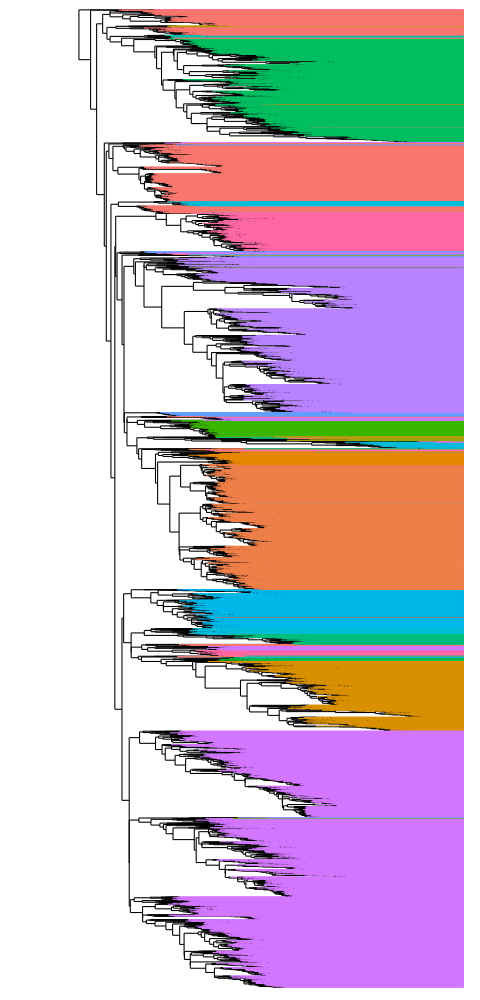

In [14]:
%%R -h 1000

plot_tree = function(physeq, color.rank="Rank2", legend.title='Phylum', 
                     plot.margin=NULL, y.expand=c(0.01,0.01),
                     legend.position='none', legend.size=4){
    # general tree plotting with ggplot
    as.Num = function(x){ x %>% as.character %>% as.numeric }
    
    # plot margin
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }

    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_inner = treeSegs$edgeDT[is.na(treeSegs$edgeDT$OTU)]
    edge_otu = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)]

    # adding taxonomy to left edges
    physeq.tax = physeq %>% tax_table %>% as.matrix %>% as.data.frame %>%
        mutate(OTU = rownames(.))
    edge_otu.df = edge_otu %>% as.matrix %>% as.data.frame %>%
        mutate(xleft = xleft %>% as.Num,
               xright = xright %>% as.Num,
               y = y %>% as.Num)
    edge_otu.df = inner_join(edge_otu.df, physeq.tax, c('OTU' = 'OTU')) %>%
        mutate(Rank2 = gsub('^__', '', Rank2),
               Rank3 = gsub('^__', '', Rank3),
               Rank4 = gsub('^__', '', Rank4),
               Rank5 = gsub('^__', '', Rank5),
               Rank6 = gsub('^__', '', Rank6),
               Rank7 = gsub('^__', '', Rank7),
               Rank8 = gsub('^__', '', Rank8)) 
    
    # adding node-metadata connector lines
    edge_otu.con = edge_otu.df %>%
                     mutate(max.xright = max(xright, na.rm=T),
                            xleft = xright,
                            xright = max.xright)
    
    # dummy facet
    edge_inner$FACET = 1
    
    # making tree plot
    p.tree = ggplot(data=edge_inner) + 
        geom_segment(aes(x=xleft, xend=xright, y=y, yend=y)) + 
        geom_segment(data=edge_otu.df, 
                     aes(x=xleft, xend=xright, y=y, yend=y)) +
        geom_segment(data=edge_otu.con,
                     aes_string(x="xleft", xend="xright", y="y", 
                                yend="y", color=color.rank)) + 
        geom_segment(data=treeSegs$vertDT, 
                     aes(x=x, xend=x, y=vmin, yend=vmax)) +
        scale_y_continuous(expand=y.expand) +
        scale_color_discrete(legend.title) +
        facet_grid(. ~ FACET) +
        theme_bw() +
        guides(colour = guide_legend(override.aes = list(size=legend.size))) +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            panel.border = element_blank(),
            panel.background = element_blank(),
            axis.title = element_blank(),
            axis.text = element_blank(),
            axis.ticks = element_blank(),
            legend.position = legend.position,
            legend.background = element_blank(),
            legend.key = element_blank(),
            strip.background = element_blank(),
            strip.text = element_blank(),
            plot.margin = plot.margin
            )
    return(p.tree)
    }

#-- test --#
p.tree = plot_tree(merge.phy, 
          legend.title='Phylum', 
          legend.position='none', 
          plot.margin=unit(c(0,-0.1,0,2),'cm'))
p.tree

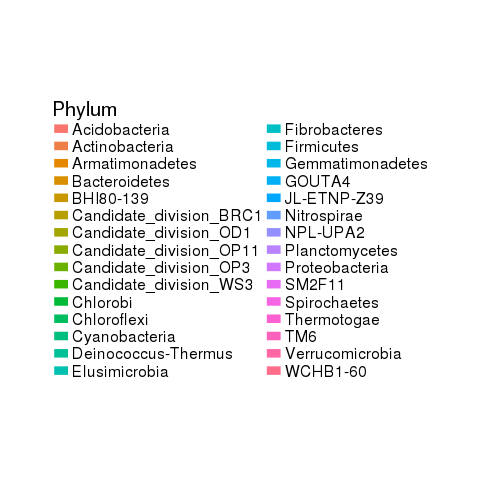

In [15]:
%%R

g_legend = function(a.gplot, text.size = 20, legend.position=c(0.5, 0.5)){ 
    # function for plotting just legend
    a.gplot = a.gplot + theme(legend.position=legend.position, 
                              text = element_text(size=text.size))
    tmp = ggplot_gtable(ggplot_build(a.gplot)) 
    leg = which(sapply(tmp$grobs, function(x) x$name) == "guide-box") 
    legend = tmp$grobs[[leg]] 
    return(legend)
    } 
                        
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [25]:
%%R 

as.Num = function(x){ x %>% as.character %>% as.numeric }

order_metadata_to_tree = function(physeq, metadata){
    # function for parsing & giving y (y.tree) value to metadata
        
    # get tree coords
    treeSegs = phyloseq:::tree_layout(phy_tree(physeq), ladderize='right')

    # edge parsing 
    edge_otu.df = treeSegs$edgeDT[! is.na(treeSegs$edgeDT$OTU)] %>%
                as.matrix %>% 
                as.data.frame %>%
                mutate(y.tree = y %>% as.Num) %>%
                select(OTU, y.tree)
    
    # joining leaf edge and metadata
    inner_join(edge_otu.df, metadata, c('OTU' = 'OTU'))     
    }

#-- test --#
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)

df.l2fc.ord = order_metadata_to_tree(merge.phy, df.l2fc.s) 
df.l2fc.ord %>% head(n=4)

       OTU y.tree log2FoldChange         p Day Plant     p.adj     RelAbund
1 OTU.4087   4981    1.763280694 0.1742325  36 FAGES 0.8275676 0.000000e+00
2 OTU.4087   4981    0.006397593 0.5982452  53 AMAPO 1.0000000 0.000000e+00
3 OTU.4087   4981    0.536219786 0.4924229  53 ECHCG 1.0000000 0.000000e+00
4 OTU.4087   4981    2.929335792 0.0664975  61 SETFA 0.4371311 5.011024e-05


# Ordering plants by phylogenetic distance

In [25]:
%%R 

# # calc wUnifrac distance
# calc.wunif.dist = function(physeq, cores=8){
#     registerDoParallel(cores=cores)
#     wunif.dist = distance(physeq,
#                           method = "unifrac", 
#                           weighted = TRUE,
#                           fast = TRUE, 
#                           parallel = TRUE, 
#                           normalized = FALSE)
#     return(wunif.dist)
#     }


# # ordering substrates by w-unifrac distances between plants
# order_plants_by_responders = function(metadata, physeq, p.adj.cutoff=0.05, ...){
   
#     # filtering physeq to just incorporators
#     responders = metadata %>%
#         filter(p.adj < p.adj.cutoff)
#     taxa.names = taxa_names(physeq)
#     taxa.to.rm = taxa.names[taxa.names %in% responders$OTU]
#     physeq.cut = prune_taxa(taxa.to.rm, physeq)
    
#     # merging samples by Plant
#     physeq.cut.merge = merge_samples(physeq.cut, "Plant")
    
#     # removing 12C-con
#     physeq.md = physeq.cut.merge %>% sample_data
#     physeq.md$Plant = rownames(physeq.md)
#     sample_data(physeq.cut.merge) = physeq.md
#     physeq.cut.merge = prune_samples(physeq.md$Plant != 'BARE', physeq.cut.merge)
        
#     # w-unifrac
#     wunif.dist = calc.wunif.dist(physeq.cut.merge, ...)
        
#     # hclust of w-unifrac values
#     wunif.clust = hclust(wunif.dist, method='average')
    
#     # ordering metadata by hclust ordering
#     Plants = metadata$Plant %>% as.vector %>% unique
#     Plants = Plants[wunif.clust$order]
#     metadata$Plant = factor(metadata$Plant, levels=Plants)
    
#     return(metadata)
# }

# #-- test --#
# #calc.wunif.dist(physeq.thresh, cores=20)
# df.l2fc.ord2 = order_plants_by_responders(df.l2fc.ord, physeq.Full, cores=nprocs)
# df.l2fc.ord2 %>% head(n=4)

       OTU y.tree log2FoldChange         p Day Plant     p.adj     RelAbund
1 OTU.4087   4981    1.763280694 0.1742325  36 FAGES 0.8275676 1.584121e-05
2 OTU.4087   4981    0.006397593 0.5982452  53 AMAPO 1.0000000 0.000000e+00
3 OTU.4087   4981    0.536219786 0.4924229  53 ECHCG 1.0000000 0.000000e+00
4 OTU.4087   4981    2.929335792 0.0664975  61 SETFA 0.4371311 2.832002e-05


In [16]:
%%R

# read phylogenetic distance, expanded with 0.0002 between maize
phy_expand = read.csv(file = "/home/bryan/RhizCG/PhyDist/phyDist_expanded.csv", header = TRUE)
colnames(phy_expand)[12] = "75-062"

pd.m = melt(as.matrix(phy_expand))

#set column names and create comparison column
colnames(pd.m) = c("PlantA", "PlantB", "phy_Dist")
pd.m$PlantComp = paste(pd.m$PlantA, pd.m$PlantB, sep = "-")
pd.m %>% head

  PlantA PlantB phy_Dist   PlantComp
1  FAGES  FAGES  0.00000 FAGES-FAGES
2  AMAPO  FAGES  0.23210 AMAPO-FAGES
3  HELAN  FAGES  0.25302 HELAN-FAGES
4  ABUTH  FAGES  0.27096 ABUTH-FAGES
5  GLYMA  FAGES  0.35879 GLYMA-FAGES
6  SORBI  FAGES  0.43476 SORBI-FAGES


In [17]:
%%R
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'
NAMdist = read.table(NAMFile, header = TRUE)
#reorder so that NAMdist is in same order as log2fold change matrix
NAMdist = NAMdist[c(1:6, 8, 7, 9, 10), c(1:6, 8, 7, 9, 10)]

nd.m = melt(as.matrix(NAMdist))

#set column names and create comparison column
colnames(nd.m) = c("PlantA", "PlantB", "gene_Dist")
nd.m$PlantComp = paste(nd.m$PlantA, nd.m$PlantB, sep = "-")
nd.m %>% head

  PlantA PlantB gene_Dist PlantComp
1    B73    B73 0.0000000   B73-B73
2    B97    B73 0.1285456   B97-B73
3    H99    B73 0.1306701   H99-B73
4  Hp301    B73 0.1357241 Hp301-B73
5  Il14H    B73 0.1412994 Il14H-B73
6    Ki3    B73 0.1413460   Ki3-B73


In [18]:
%%R
#Join distance tables
Dist = left_join(pd.m, nd.m[,c(3,4)], by = "PlantComp")
#scale phydist by namDist using ifelse statement to remove NAs
Dist$TreeDist = ifelse(is.na(Dist$gene_Dist), Dist$phy_Dist, Dist$phy_Dist*Dist$gene_Dist)
head(Dist)

  PlantA PlantB phy_Dist   PlantComp gene_Dist TreeDist
1  FAGES  FAGES  0.00000 FAGES-FAGES        NA  0.00000
2  AMAPO  FAGES  0.23210 AMAPO-FAGES        NA  0.23210
3  HELAN  FAGES  0.25302 HELAN-FAGES        NA  0.25302
4  ABUTH  FAGES  0.27096 ABUTH-FAGES        NA  0.27096
5  GLYMA  FAGES  0.35879 GLYMA-FAGES        NA  0.35879
6  SORBI  FAGES  0.43476 SORBI-FAGES        NA  0.43476


In [19]:
%%R
Dist.c = cast(Dist[,c(1,2,6)], PlantA~PlantB, mean) %>% as.dist


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Using TreeDist as value column.  Use the value argument to cast to override this choice

  res = super(Function, self).__call__(*new_args, **new_kwargs)



Call:
hclust(d = as.dist(Dist.c), method = "average")

Cluster method   : average 
Number of objects: 22 



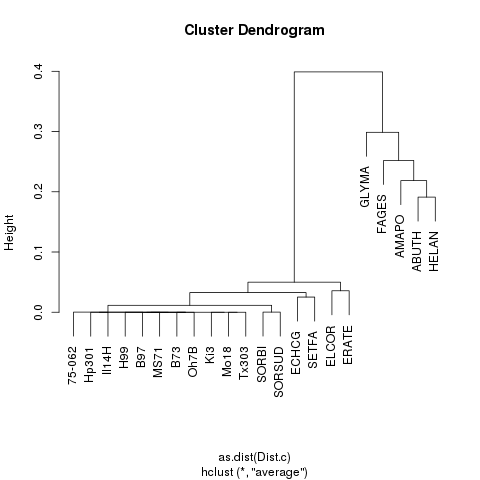

In [20]:
%%R
Dist_hc = hclust(as.dist(Dist.c), "average")
plot(Dist_hc)
Dist_hc

### non function form, define order based on tree above

In [26]:
%%R


# ordering substrates by w-unifrac distances between plants
order_metadata_by_phylogeny = function(metadata, ...){
    
    Plants = c("75-062", "Hp301", "Il14H", "H99", "B97", "MS71", "B73", "Oh7B", "Ki3", "Mo18", "Tx303", "SORBI",
  "SORSUD", "ECHCG", "SETFA", "ELCOR", "ERATE", "GLYMA", "FAGES", "AMAPO", "ABUTH", "HELAN")
    
    metadata$Plant = factor(metadata$Plant, levels=Plants)
    
    return(metadata)
 }

# #-- test --#

df.l2fc.ord2 = order_metadata_by_phylogeny(df.l2fc.ord)
df.l2fc.ord2 %>% head(n=4)

       OTU y.tree log2FoldChange         p Day Plant     p.adj     RelAbund
1 OTU.4087   4981    1.763280694 0.1742325  36 FAGES 0.8275676 0.000000e+00
2 OTU.4087   4981    0.006397593 0.5982452  53 AMAPO 1.0000000 0.000000e+00
3 OTU.4087   4981    0.536219786 0.4924229  53 ECHCG 1.0000000 0.000000e+00
4 OTU.4087   4981    2.929335792 0.0664975  61 SETFA 0.4371311 5.011024e-05


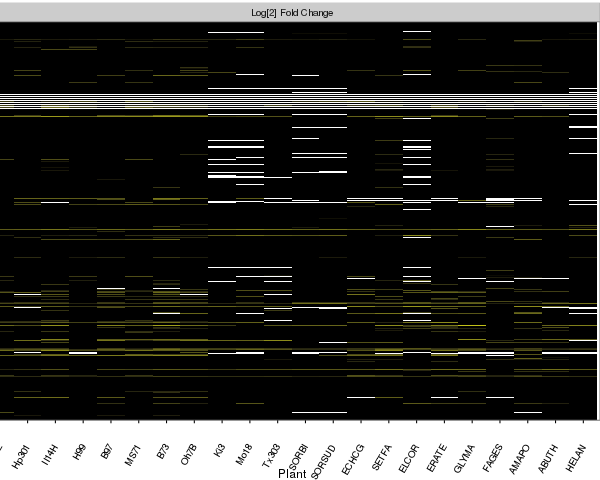

In [313]:
%%R -w 600

# function for making incorporator plot
responders_plot = function(metadata, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0.1,0,0,-0.7), "cm")  # top, right, bottom, left        
    }
    

metadata.ord = metadata %>%
        mutate(responder = p.adj < 0.05,
               responder.num = responder %>% as.numeric,
               Day = Day %>% as.character)
    
    metadata.ord$Day = reorder(metadata.ord$Day, metadata.ord$Day %>% as.numeric)

    min.y = metadata.ord$y.tree %>% min(na.rm=T)
    max.y = metadata.ord$y.tree %>% max(na.rm=T) 
# add dummy variable to allow faceting
metadata.ord$FacetLabel = rep("Log[2] Fold Change", nrow(metadata.ord)) %>% as.factor()

Responders = filter(metadata.ord, p.adj <0.05 & log2FoldChange > 0)
    NonResp = filter(metadata.ord, p.adj >0.05 )
    Filtered = filter(metadata.ord, is.na(p.adj))
    
p.responder = ggplot() + 
    geom_tile(data = NonResp, aes(Plant, y.tree), fill = "black") +
    scale_y_continuous(expand=c(0,0)) +

    geom_tile(data = Responders, aes(Plant, y.tree, fill = log2FoldChange)) +
    scale_fill_gradient( low = "black", high = "yellow", guide = 'none')+ #limit = c(.00001733848, .0555003)) +
    #scale_y_continuous(expand=c(0,0)) +

       facet_grid(. ~ FacetLabel, scales='free_x') +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=60, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            ) 
    return(p.responder)
    }

#-- test --#
p.responders = responders_plot(df.l2fc.ord2)
p.responders

# Functions for bulk soil abundance plot

In [283]:
%%R
bulk_abund_plot_df = function(physeq, metadata){
 
    meta.pos = metadata[,c("OTU","y.tree")] %>% unique
    
    
    tbl.otu = physeq.Full.thresh %>% 
        otu_table %>% 
        .["BARE",] %>% 
        t() %>% 
        as.data.frame 
    
    
    tbl.otu$OTU = row.names(tbl.otu)
    colnames(tbl.otu) = c("RelAbund", "OTU")
    
    tbl.otu.ord = left_join(tbl.otu, meta.pos, by = "OTU")
    
        

return(tbl.otu.ord)
    }
## test ##
bare.df = bulk_abund_plot_df(physeq.Full.thresh , df.l2fc.ord)
head(bare.df) %>% print
#

      RelAbund      OTU y.tree
1 0.0012681804  OTU.212    546
2 0.0005914094  OTU.246    544
3 0.0026469645   OTU.93    545
4 0.0005310075  OTU.239    543
5 0.0010102171 OTU.5917    540
6 0.0009327741 OTU.3241    539


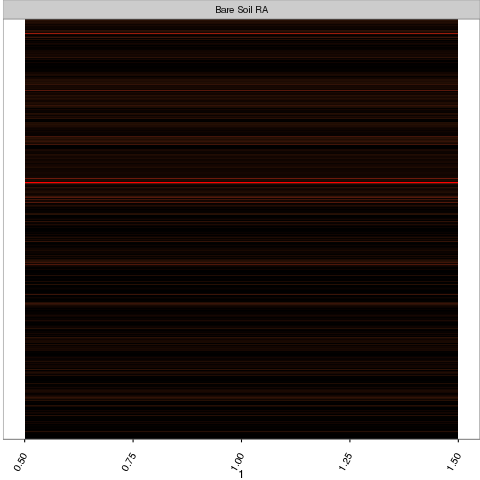

In [307]:
%%R
bareAbundance_plot = function(bare_df, plot.margin=NULL){
    if(is.null(plot.margin)){
        plot.margin = unit(c(0,0,0,0), "cm")  # top, right, bottom, left        
    }
    

    min.y = bare_df$y.tree %>% min(na.rm=T)
    max.y = bare_df$y.tree %>% max(na.rm=T) 
# add dummy variable to allow faceting
bare_df$FacetLabel = rep("Bare Soil RA", nrow(bare_df)) %>% as.factor()

    
bare.plot = ggplot() + 
    geom_tile(data = bare_df, aes(x = 1, y.tree, fill = RelAbund)) +
    scale_fill_gradient( low = "black", high = "red", guide = 'none')+ #limit = c(.00001733848, .0555003)) +
    scale_y_continuous(expand=c(0,0)) +

       facet_grid(. ~ FacetLabel, scales='free_x') +
        theme_bw() +
        theme(
            panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            axis.text.x = element_text(angle=60, vjust=0.5, hjust=1),
            axis.title.y = element_blank(),
            axis.text.y = element_blank(),
            axis.ticks.y = element_blank(),
            legend.position = 'none',
            plot.margin = plot.margin    
            ) 
    return(bare.plot)
    }

#test#
bare.plot = bareAbundance_plot(bare.df)
bare.plot

# Core microbiome panel

In [98]:
%%R
CoreDF = read.csv(file = "/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/OTUexploration/CoreTaxa.csv", header = TRUE)
CoreDF = CoreDF[,-1]


In [109]:
%%R
head(CoreDF)

        OTU MaizeCore C4Core DicotCore PanicoideaeCore PaniceaeCore
1    OTU.10         1      1         1               1            1
2   OTU.101         1     NA        NA              NA            1
3 OTU.10253         1      1         1               1            1
4 OTU.10288         1      1         1               1            1
5  OTU.1034         1      1         1               1            1
6   OTU.104         1     NA         1              NA           NA
  AndropogoneaeCore ChloridoideaeCore
1                 1                 1
2                NA                NA
3                 1                 1
4                 1                 1
5                 1                 1
6                 1                 1


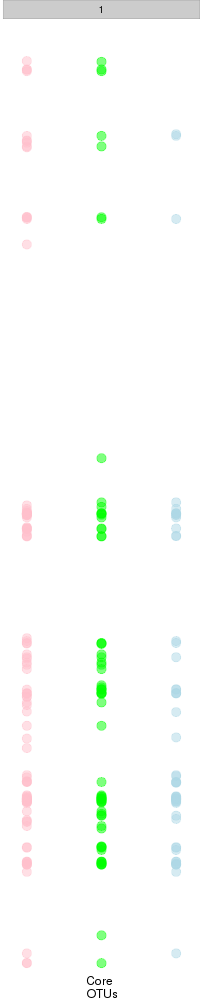

In [335]:
%%R -h 1000 -w 200

plot_core = function(metadata, core){
    
#   if(is.null(plot.margin)){
#      plot.margin = unit(c(0.0,0,0,-0.7), "cm")}  # top, right, bottom, left        
    
dodge <- position_dodge(width=0.05)

meta.pos = metadata[,c("OTU","y.tree")] %>% unique
meta.core = inner_join(core, meta.pos, by = "OTU")
ymax = max(meta.pos$y.tree)

Core.df = meta.core[,c("OTU", "MaizeCore", "C4Core", "DicotCore", "y.tree")] %>% 
    melt(id=c("OTU","y.tree")) %>% 
    subset(value == 1)  
Core.df$variable = factor(Core.df$variable, levels = c("MaizeCore", "C4Core", "DicotCore" ))
CorePlot =    ggplot(Core.df) +
        geom_point(aes(x = 1, y = y.tree, color = variable), position = dodge, size = 4, alpha = 0.5)+
        scale_color_manual(values = c("pink", "green", "lightblue"))+
        #geom_jitter(width = .01, height = 0) + 
        xlim(.98,1.02) +
        scale_y_continuous(limits=c(0, ymax), expand = c(0, 0))+
       theme_bw() +
        theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(), axis.line.y = element_blank(), 
              plot.background = element_blank(),
                 plot.margin = unit(c(0.0,0,0,0), "cm"),
              axis.text.x = element_blank(), axis.text.y = element_blank(), 
              axis.ticks.y = element_blank(), axis.title.y = element_blank(),
              axis.ticks.x = element_blank(), panel.border = element_blank(),
             legend.position = "none") +
        xlab("Core \n OTUs") +
        facet_grid(. ~ value)
        

    return(CorePlot)
    }
    
#-- test --#
p.core = plot_core(df.l2fc.ord2, CoreDF)
p.core

# Function to resize ggplots

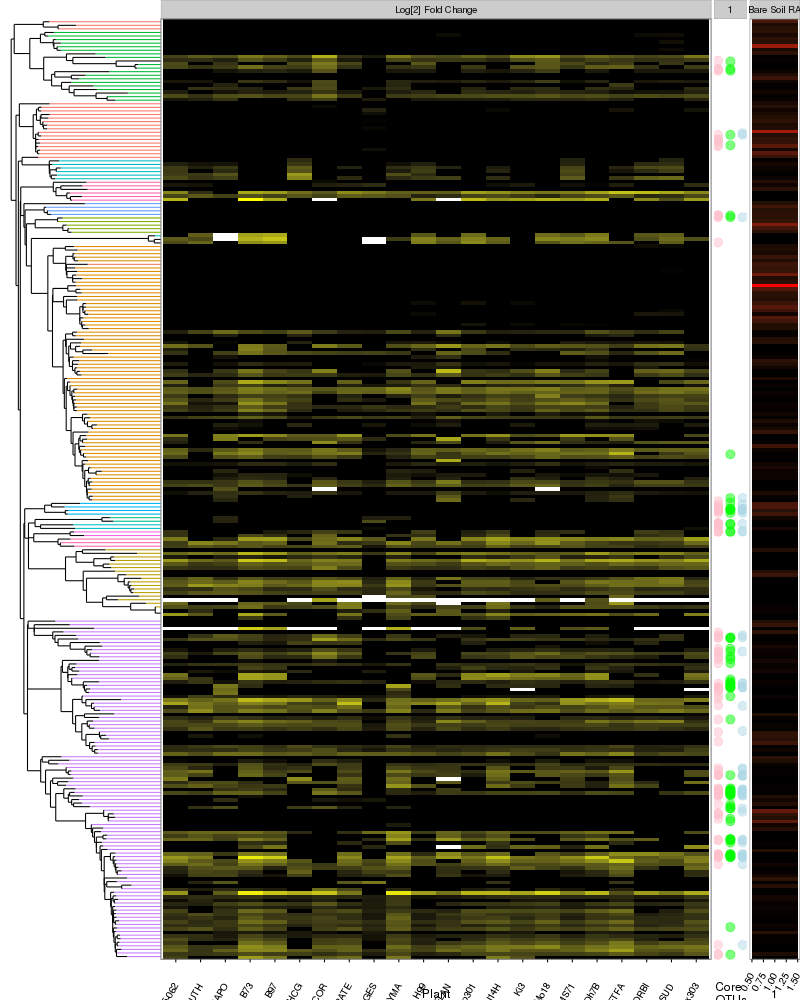

In [336]:
%%R -w 800 -h 1000
    
resize_ggplots = function(ggplot.list,
                          resize.index = length(ggplot.list),
                          widths=rep(1, length(ggplot.list))){
    # other.plots = list of plots
    stopifnot(class(ggplot.list)[1] == 'list')
    
    ## making gtables
    make_gt = function(x) ggplot_gtable(ggplot_build(x))
    gt = lapply(ggplot.list, make_gt)
        
    # resizing
    gt.len = length(gt)    
    for(i in 1:gt.len){
        if(i == resize.index){
            next
        } else {
            gt[[i]]$heights = gt[[resize.index]]$heights
        }
    }
        
    # grid.arrange params
    params.l = list('ncol' = gt.len, 'widths' = widths)

    # return list of gtables + params
    return(c(gt, params.l))
    } 

x = resize_ggplots(list(p.tree, p.responders, p.core, bare.plot), 
                   widths=c(.6,1.8,0.12, 0.18))
do.call(grid.arrange, x)

## full tree; just incorporators with greather than 0.001 rel abund

In [338]:
%%R
# adding incorporator status to tax_table
resp.list = df.l2fc %>%
        filter(p.adj < 0.05 & RelAbund > 0.001 & log2FoldChange > 0) %>%
    .$OTU %>%  
    unique 
merge.phy.resp =  prune_taxa(resp.list, merge.phy)


merge.phy.resp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 340 taxa and 22 samples ]
sample_data() Sample Data:       [ 22 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 340 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 340 tips and 339 internal nodes ]


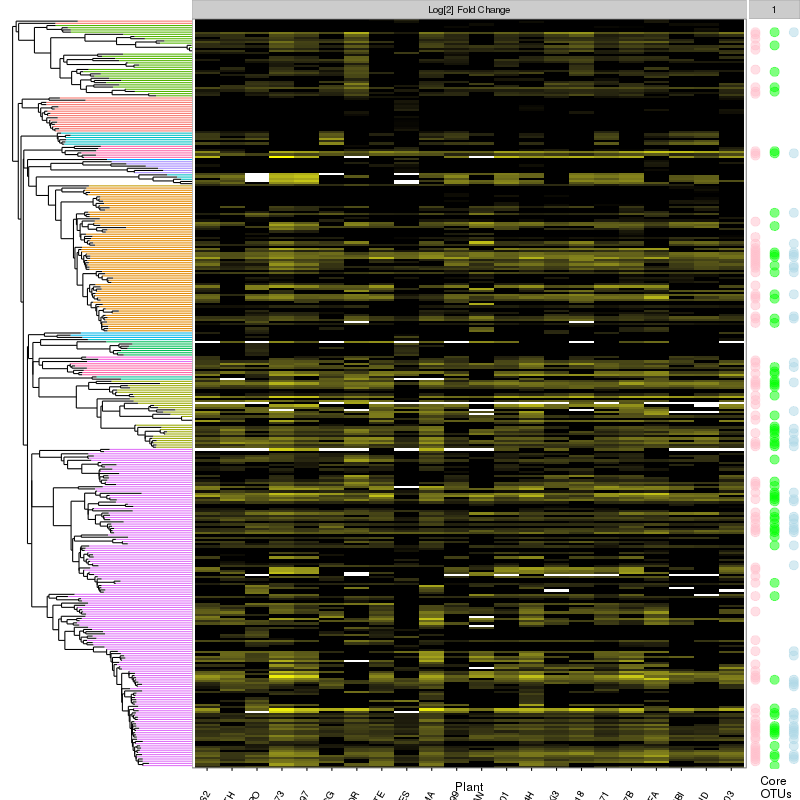

In [339]:
%%R -w 800 -h 800

p.tree = plot_tree(merge.phy.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.2,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(merge.phy.resp, df.l2fc.s) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

#plot core dataset inclusion
p.core = plot_core(df.l2fc.ord, CoreDF)

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.core),
                    widths=c(0.7,1.8,.18))
do.call(grid.arrange, gt)

# Full tree all OTUs greater than 0.0001 relative abundance in 3 samples

In [340]:
%%R
# adding incorporator status to tax_table
# resp.list = df.l2fc %>%
#         filter(p.adj < 0.05 & RelAbund > 0.001 & log2FoldChange > 0) %>%
#     .$OTU %>%  
#     unique 
# merge.phy.resp =  prune_taxa(resp.list, merge.phy)
physeq.Full.thresh =  merge_samples(physeq.Full, "Plant") %>%
                transform_sample_counts(function(x) x/sum(x)) %>%
                filter_taxa(function(x) sum(x > 0.002) > 0, TRUE)

physeq.Full.thresh

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 263 taxa and 23 samples ]
sample_data() Sample Data:       [ 23 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 263 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 263 tips and 262 internal nodes ]


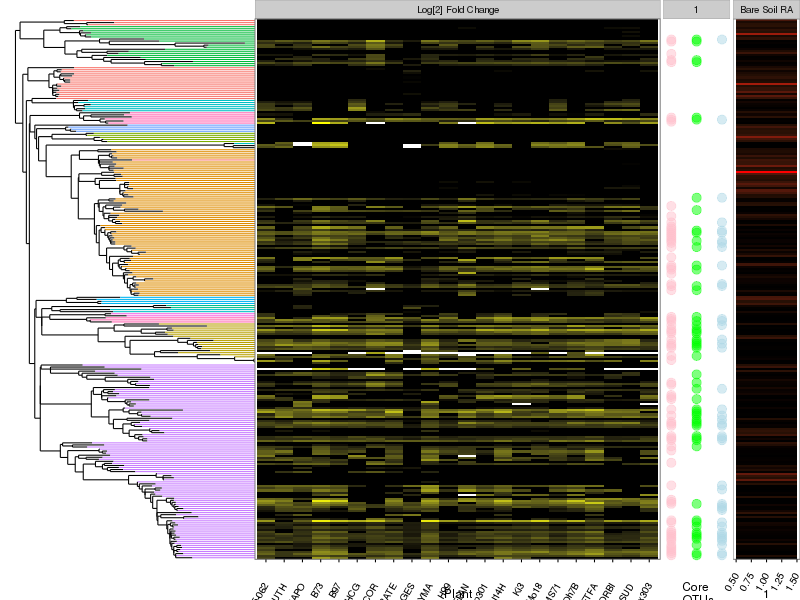

In [344]:
%%R -w 800 -h 600

p.tree = plot_tree(physeq.Full.thresh, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.2,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.thresh, df.l2fc.s) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# plot bulk abundance
bare.df = bulk_abund_plot_df(physeq.Full.thresh , df.l2fc.ord)
bare.plot = bareAbundance_plot(bare.df)

#plot core dataset inclusion
p.core = plot_core(df.l2fc.ord, CoreDF)

# plotting
gt = resize_ggplots(list(p.tree, p.responders, p.core, bare.plot),
                    widths=c(0.7,1,.18, 0.18))
do.call(grid.arrange, gt)

In [45]:
%%R
# # saving figure
# outFile = 'allPhyla-resp_thresh_sparCut3in3_relabund.pdf'
# outFile = paste(c(figDir, outFile), collapse='/')
# pdf(outFile, width=800 / 65, height=800 / 65)
# do.call(grid.arrange, gt)
# dev.off()


Error in do.call(grid.arrange, gt) : object 'gt' not found


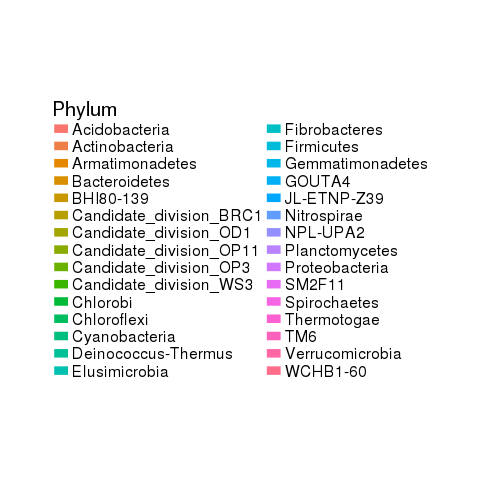

In [345]:
%%R 
# # saving legend
# outFile = 'allPhyla-resp_thresh_w-relabund_leg.pdf'
# outFile = paste(c(figDir, outFile), collapse='/')
# pdf(outFile, width=500 / 65, height=500 / 65)
# my.legend = g_legend(p.tree)
# grid.draw(my.legend)
# dev.off()
grid.draw(my.legend)

### simple plot not bulk abundance data organized by DAP

In [47]:
%%R -w 800 -h 800

p.tree = plot_tree(physeq.Full.resp, 
                   legend.title=' Phylum', 
                   y.expand=c(0.003,0.003),
                   plot.margin=unit(c(0,-0.2,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full.resp, df.l2fc.s) 
## substrates by similarity of incorporators
df.l2fc.ord = order_plants_by_day(df.l2fc.ord, physeq.Full.resp, cores=nprocs)

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)

# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.3))
do.call(grid.arrange, gt)


Error in withVisible({ : could not find function "order_plants_by_day"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : could not find function "order_plants_by_day"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [48]:
%%R
# saving figure
outFile = 'allPhyla-resp_byDay_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=800 / 65)
do.call(grid.arrange, gt)
dev.off()


Error in do.call(grid.arrange, gt) : object 'gt' not found


In [49]:
%%R 
# saving legend
outFile = 'allPhyla-resp_byDay_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


# Figures for each phylum

In [50]:
%%R
# ordering plants by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Plant %>% levels
full.tree.ord

NULL


In [51]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Proteobacteria"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3', 
                   legend.title='Class',
                   y.expand=c(0.002,0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord)


# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.5))
do.call(grid.arrange, gt)


Error in withVisible({ : 
  could not find function "order_plants_by_phylogeny"


# Figures for each phylum

In [52]:
%%R
# ordering substrates by full tree order (all incorporators)
full.tree.ord = df.l2fc.ord$Plant %>% levels
full.tree.ord

NULL


In [53]:
%%R
# total OTU counts for each day (for normalizing)
# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq.Full, df.l2fc.s) 

# bulk abundance plots
df.bulk = bulk_abund_plot_df(physeq.Full, df.l2fc.ord) 

# total OTU counts for bulk soils
total.counts = df.bulk %>% 
    group_by(Day) %>%
    summarize(total_count = sum(count)) %>%
    as.data.frame 

total.counts


Error in withVisible({ : could not find function "bulk_abund_plot_df"


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in withVisible({ : could not find function "bulk_abund_plot_df"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


# Table summary of responders at phylum level

### Number of responders per phylum of abundant taxa (> 0.001 relative abundance)

In [54]:
%%R
physeq.tax = physeq.Full.resp  %>% tax_table %>% as.matrix %>% as.data.frame
physeq.tax$Rank2 %>% table %>% sort(decreasing=T)

.
  Proteobacteria   Actinobacteria      Chloroflexi    Bacteroidetes 
             139               66               33               30 
   Acidobacteria       Firmicutes  Verrucomicrobia    Cyanobacteria 
              17               12               11                6 
  Planctomycetes    Fibrobacteres Gemmatimonadetes     Spirochaetes 
               6                2                2                2 
 Armatimonadetes 
               1 


In [55]:
%%R
R %>% head


Error in eval(expr, envir, enclos) : object 'R' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in eval(expr, envir, enclos) : object 'R' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [56]:
%%R
#list of OTUs to trim physeq object
R = df.l2fc %>% filter(p.adj < 0.05)
mytaxa = as.character(R$OTU)

#Trim phyloseq object
merge.R = merge.phy %>% subset_samples(Plant != "BARE") 
merge.R = prune_taxa(mytaxa, merge.R)
merge.R

#Export to dataframe and join with log2F table
PlantRel = merge.R %>% otu_table %>%  t() %>% as.data.frame 

PlantRel$OTU = rownames(PlantRel)

#Export taxonomy
Taxonomy = merge.R %>% tax_table %>% as.data.frame
Taxonomy$OTU = rownames(Taxonomy) 

PlantRel = inner_join(Taxonomy, PlantRel, by = "OTU")
PlantRel %>% head



     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia               MVP-88 uncultured_bacterium  <NA>  <NA>
6 Bacteria   Chloroflexi          Gitt-GS-136                 <NA>  <NA>  <NA>
  Rank7 Rank8      OTU       75-062        ABUTH        AMAPO          B73
1  <NA>  <NA> OTU.4087 0.000000e+00 0.000000e+00 0.000000e+00 8.669242e-06
2  <NA>  <NA> OTU.2009 3.511441e-05 0.000000e+00 3.386253e-05 8.958217e-05
3  <NA>  <NA> OTU.1285 9.754004e-05 9.967219e-05 1.749564e-04 4.912571e-05
4  <NA>  <NA> OTU.3513 1.950801e-05 1.107469e-05 2.821877e-05 1.733848e-05
5  <NA>  <NA> OTU.6694 1.950801e-05 2.214938e-05 1.693126e-05 3.467697e-

# Phylum stats

In [57]:
%%R
dim(PlantRel)

[1] 1506   31


In [58]:
%%R
colnames(PlantRel)

 [1] "Rank1"  "Rank2"  "Rank3"  "Rank4"  "Rank5"  "Rank6"  "Rank7"  "Rank8" 
 [9] "OTU"    "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR" 
[17] "ERATE"  "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"   
[25] "Mo18"   "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303" 


In [59]:
%%R
#calculating OTU stats
PlantRel$min = apply(PlantRel[,10:31], 1, FUN = min)
PlantRel$max = apply(PlantRel[,10:31], 1, FUN = max)
PlantRel$median = apply(PlantRel[,10:31], 1, FUN = min)
PlantRel %>% head

     Rank1         Rank2                Rank3                Rank4 Rank5 Rank6
1 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
2 Bacteria           TM6 uncultured_bacterium                 <NA>  <NA>  <NA>
3 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
4 Bacteria Elusimicrobia          Lineage_IIb uncultured_bacterium  <NA>  <NA>
5 Bacteria Elusimicrobia               MVP-88 uncultured_bacterium  <NA>  <NA>
6 Bacteria   Chloroflexi          Gitt-GS-136                 <NA>  <NA>  <NA>
  Rank7 Rank8      OTU       75-062        ABUTH        AMAPO          B73
1  <NA>  <NA> OTU.4087 0.000000e+00 0.000000e+00 0.000000e+00 8.669242e-06
2  <NA>  <NA> OTU.2009 3.511441e-05 0.000000e+00 3.386253e-05 8.958217e-05
3  <NA>  <NA> OTU.1285 9.754004e-05 9.967219e-05 1.749564e-04 4.912571e-05
4  <NA>  <NA> OTU.3513 1.950801e-05 1.107469e-05 2.821877e-05 1.733848e-05
5  <NA>  <NA> OTU.6694 1.950801e-05 2.214938e-05 1.693126e-05 3.467697e-

In [60]:
%%R
#calculate OTU stats for each phyla
OTU_level = PlantRel %>% group_by(Rank2) %>%
    summarize(Median = median(median),
             Max = mean(max),
             Min = min(min), 
            count = length(Rank2)) %>%
     arrange(desc(count))
colnames(OTU_level) = c("Rank2", "OTU_Median", "OTU_Max", "OTU_Min", "OTU_count")
OTU_level

# A tibble: 20 x 5
                     Rank2   OTU_Median      OTU_Max OTU_Min OTU_count
                    <fctr>        <dbl>        <dbl>   <dbl>     <int>
1           Proteobacteria 7.920604e-06 1.551604e-03       0       507
2            Bacteroidetes 0.000000e+00 8.045637e-04       0       206
3           Actinobacteria 5.534924e-05 2.954526e-03       0       174
4              Chloroflexi 1.827978e-05 7.833390e-04       0       158
5           Planctomycetes 0.000000e+00 2.918767e-04       0       144
6          Verrucomicrobia 8.945531e-06 9.689389e-04       0        93
7               Firmicutes 0.000000e+00 2.794551e-03       0        58
8            Acidobacteria 3.894743e-05 9.631878e-04       0        56
9         Gemmatimonadetes 1.173017e-05 4.003143e-04       0        38
10           Cyanobacteria 0.000000e+00 6.771842e-04       0        24
11         Armatimonadetes 0.000000e+00 2.717567e-04       0        21
12           Fibrobacteres 0.000000e+00 4.760396e-04      

In [61]:
%%R
colnames(PlantRel)

 [1] "Rank1"  "Rank2"  "Rank3"  "Rank4"  "Rank5"  "Rank6"  "Rank7"  "Rank8" 
 [9] "OTU"    "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR" 
[17] "ERATE"  "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"   
[25] "Mo18"   "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303"  "min"   
[33] "max"    "median"


In [62]:
%%R
colnames(PL)


Error in is.data.frame(x) : object 'PL' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in is.data.frame(x) : object 'PL' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [63]:
%%R
#calculate OTU stats for each phyla
PL = PlantRel[,c(2,10:31)] %>% group_by(Rank2) %>%
    summarize_each(funs(sum))
PL$Max_relabund = apply(PL[,2:23], 1, FUN = max)
PL$Min_relabund = apply(PL[,2:23], 1, FUN = min)
PL$Median_relabund = apply(PL[,2:23], 1, FUN = median)
Phylum_level = (PL[,c("Rank2", "Min_relabund", "Max_relabund", "Median_relabund" )])
Phylum_level

# A tibble: 20 x 4
                     Rank2 Min_relabund Max_relabund Median_relabund
                    <fctr>        <dbl>        <dbl>           <dbl>
1            Acidobacteria 9.346739e-03 0.0513215528    1.952954e-02
2           Actinobacteria 1.002075e-01 0.3194437427    1.595892e-01
3          Armatimonadetes 1.270860e-03 0.0036801173    2.101607e-03
4            Bacteroidetes 1.624289e-02 0.0740449363    4.066342e-02
5  Candidate_division_BRC1 2.315887e-05 0.0008633458    8.565661e-05
6   Candidate_division_OD1 0.000000e+00 0.0001227694    3.790324e-05
7                 Chlorobi 2.526146e-05 0.0003168242    1.044845e-04
8              Chloroflexi 1.751203e-02 0.0911404051    4.467883e-02
9            Cyanobacteria 7.577671e-04 0.0124907923    2.480864e-03
10     Deinococcus-Thermus 0.000000e+00 0.0003592252    4.313640e-05
11           Elusimicrobia 1.263073e-05 0.0004712759    1.376651e-04
12           Fibrobacteres 2.214938e-05 0.0035219873    5.453321e-04
13             

In [64]:
%%R
Tbl = full_join(OTU_level, Phylum_level, by = "Rank2") %>% arrange(desc(OTU_count))
Tbl
write.csv(Tbl, file = '/home/bryan/RhizCG/figures/PhylumStats.csv', sep = ",")

## Family level

In [ ]:
%%R
#Check annotation at and cla

In [70]:
%%R
PlantRel %>% 
    filter(Rank5 == "Streptomycetaceae" | Rank4 == "Streptomycetaceae" ) %>% 
    .[,1:7] %>% unique

     Rank1          Rank2            Rank3             Rank4        Rank5 Rank6
1 Bacteria Actinobacteria Streptomycetales Streptomycetaceae Streptomyces  <NA>
  Rank7
1  <NA>


In [74]:
%%R
physeq.Full %>% 
    tax_table %>%
    as.data.frame %>%
    filter(Rank5 == "Streptomycetaceae" | Rank4 == "Streptomycetaceae" ) %>% 
    .[,1:7] %>% unique

     Rank1          Rank2            Rank3             Rank4        Rank5 Rank6
1 Bacteria Actinobacteria Streptomycetales Streptomycetaceae Streptomyces  <NA>
  Rank7
1  <NA>


In [75]:
%%R
physeq.Full %>% 
    tax_table %>%
    as.data.frame %>%
    filter(Rank5 == "Comamonadaceae") %>% 
    .[,1:7] %>% unique

      Rank1          Rank2              Rank3           Rank4          Rank5
1  Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
3  Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
5  Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
6  Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
7  Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
12 Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
15 Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
23 Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
24 Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
26 Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
28 Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae
32 Bacteria Proteobacteria Betaproteobacteria Burkholderiales Comamonadaceae

In [414]:
%%R
#calculate OTU stats for each phyla
OTU_level = PlantRel %>% group_by(Rank2, Rank3, Rank4, Rank5) %>%
    summarize(
                Median = median(median),
             Max = mean(max),
             Min = min(min), 
            count = length(Rank5)) %>%
     arrange(desc(count))
colnames(OTU_level) = c("Rank2", "Rank3", "Rank4", "Rank5", "OTU_Median", "OTU_Max", "OTU_Min", "OTU_count")
OTU_level

Source: local data frame [251 x 8]
Groups: Rank2, Rank3, Rank4 [136]

           Rank2                          Rank3
          (fctr)                         (fctr)
1  Acidobacteria                          11-24
2  Acidobacteria Candidatus_Chloracidobacterium
3  Acidobacteria Candidatus_Chloracidobacterium
4  Acidobacteria Candidatus_Chloracidobacterium
5  Acidobacteria          Candidatus_Solibacter
6  Acidobacteria                          DA023
7  Acidobacteria                          DA023
8  Acidobacteria                          DA023
9  Acidobacteria                         DS-100
10 Acidobacteria                     Holophagae
..           ...                            ...
Variables not shown: Rank4 (fctr), Rank5 (fctr), OTU_Median (dbl), OTU_Max
  (dbl), OTU_Min (dbl), OTU_count (int)


In [415]:
%%R
colnames(PlantRel)

 [1] "Rank1"  "Rank2"  "Rank3"  "Rank4"  "Rank5"  "Rank6"  "Rank7"  "Rank8" 
 [9] "OTU"    "75-062" "ABUTH"  "AMAPO"  "B73"    "B97"    "ECHCG"  "ELCOR" 
[17] "ERATE"  "FAGES"  "GLYMA"  "H99"    "HELAN"  "Hp301"  "Il14H"  "Ki3"   
[25] "Mo18"   "MS71"   "Oh7B"   "SETFA"  "SORBI"  "SORSUD" "Tx303"  "min"   
[33] "max"    "median"


In [419]:
%%R
#calculate OTU stats for each phyla
FL = PlantRel[,c(2,3,4,5,10:31)] %>% group_by(Rank2, Rank3, Rank4, Rank5) %>%
    summarize_each(funs(sum))
colnames(FL)
FL$Max_relabund = apply(FL[,5:26], 1, FUN = max)
FL$Min_relabund = apply(FL[,5:26], 1, FUN = min)
FL$Median_relabund = apply(FL[,5:26], 1, FUN = median)
Family_level = (FL[,c("Rank2", "Rank3", "Rank4","Rank5", "Min_relabund", "Max_relabund", "Median_relabund" )])
Family_level

Source: local data frame [251 x 7]
Groups: Rank2, Rank3, Rank4 [136]

           Rank2                          Rank3
          (fctr)                         (fctr)
1  Acidobacteria                          11-24
2  Acidobacteria Candidatus_Chloracidobacterium
3  Acidobacteria Candidatus_Chloracidobacterium
4  Acidobacteria Candidatus_Chloracidobacterium
5  Acidobacteria          Candidatus_Solibacter
6  Acidobacteria                          DA023
7  Acidobacteria                          DA023
8  Acidobacteria                          DA023
9  Acidobacteria                         DS-100
10 Acidobacteria                     Holophagae
..           ...                            ...
Variables not shown: Rank4 (fctr), Rank5 (fctr), Min_relabund (dbl),
  Max_relabund (dbl), Median_relabund (dbl)


In [421]:
%%R
Tbl = full_join(OTU_level, Family_level) %>% arrange(desc(OTU_count))
Tbl
write.csv(Tbl, file = '/home/bryan/RhizCG/figures/FamilyStats.csv', sep = ",")

In [1]:
%%R


ERROR: Cell magic `%%R` not found.


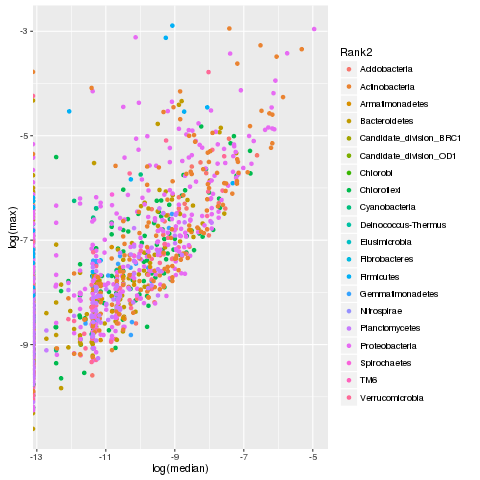

In [431]:
%%R
ggplot(PlantRel, aes(x = log(median), y = log(max), colour = Rank2)) + 
    geom_point()

In [305]:
%%R
df.l2fc %>% filter(p.adj < 0.05) %>%
    group_by(OTU) %>%
    summarize(Rel = mean(RelAbund),
             l2f = mean(log2FoldChange),
             Phylum = first(Rank2)) %>%
    group_by(Phylum) %>%
     summarize(count = length(Phylum),
                  RelAbund = mean(Rel),
                    L2F = mean(l2f)) %>%
     arrange(desc(count))

Source: local data frame [20 x 4]

                    Phylum count     RelAbund      L2F
                    (fctr) (int)        (dbl)    (dbl)
1           Proteobacteria   507 6.658721e-04 4.027051
2            Bacteroidetes   206 2.969870e-04 4.315679
3           Actinobacteria   174 1.363705e-03 3.202288
4              Chloroflexi   158 4.083371e-04 3.364895
5           Planctomycetes   144 2.434705e-04 2.666013
6          Verrucomicrobia    93 4.385508e-04 3.860752
7               Firmicutes    58 7.028826e-04 4.808561
8            Acidobacteria    56 8.354507e-04 2.350185
9         Gemmatimonadetes    38 3.380225e-04 2.730885
10           Cyanobacteria    24 3.652760e-04 3.887706
11         Armatimonadetes    21 1.520715e-04 3.979465
12           Fibrobacteres     8 1.837690e-04 4.372810
13            Spirochaetes     5 2.862844e-04 4.174627
14 Candidate_division_BRC1     3 2.025618e-04 3.087652
15           Elusimicrobia     3 2.020810e-04 3.410570
16                Chlorobi    

## Proteobacteria

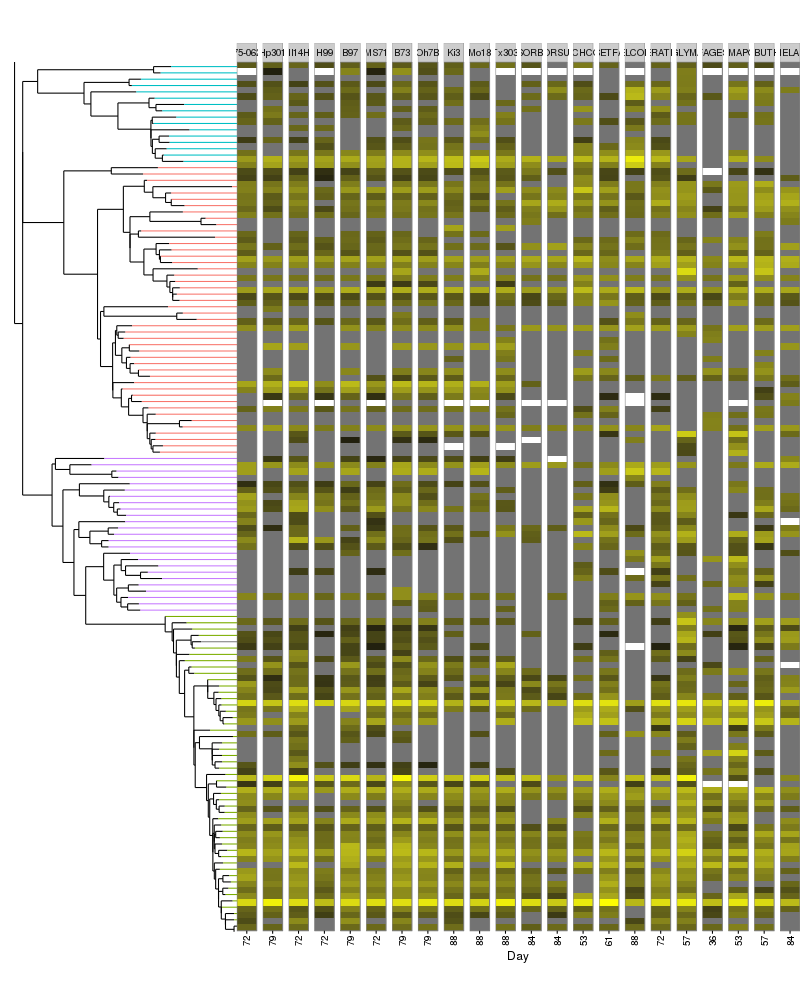

In [229]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Proteobacteria"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, color.rank='Rank3', legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(0.7,1.5))
do.call(grid.arrange, gt)

In [203]:
%%R -i figDir

#outFile = 'Proteo_sparsityCut.pdf'
#outFile = paste(c(figDir, outFile))#, collapse='/')
outFile = 'Proteo_sparsityCut.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
#outFile = file.path(figDir, 'Proteo_sparsityCut.pdf')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


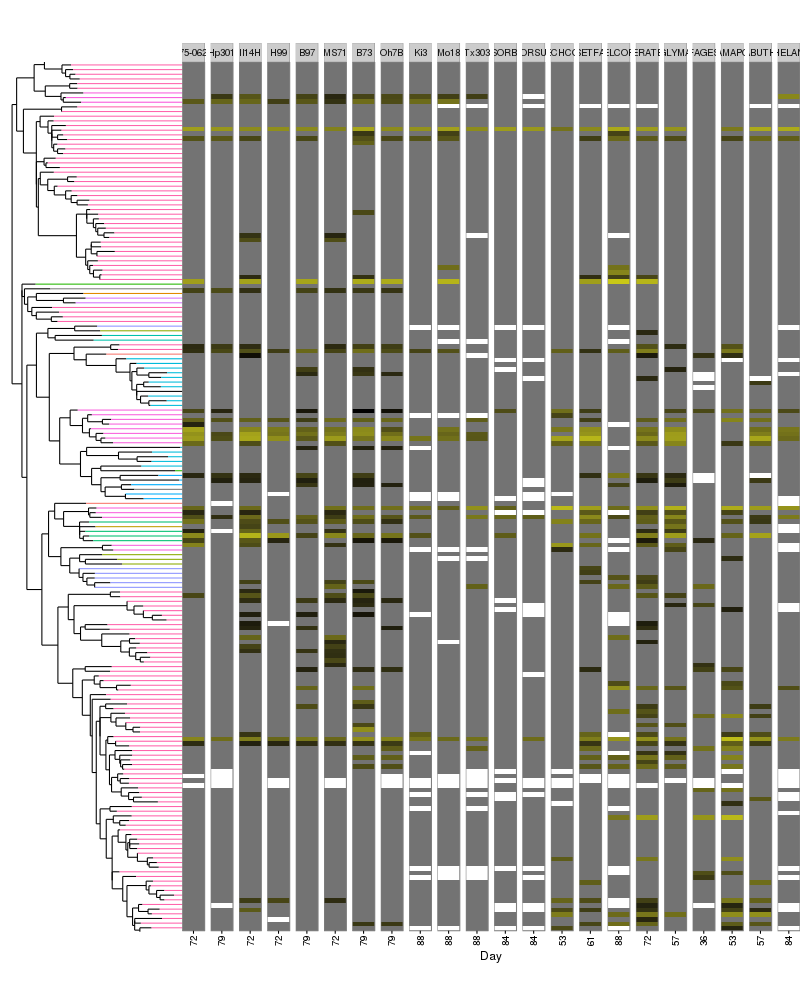

In [231]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Gammaproteobacteria"
physeq_1phy = subset_taxa(physeq.Full, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

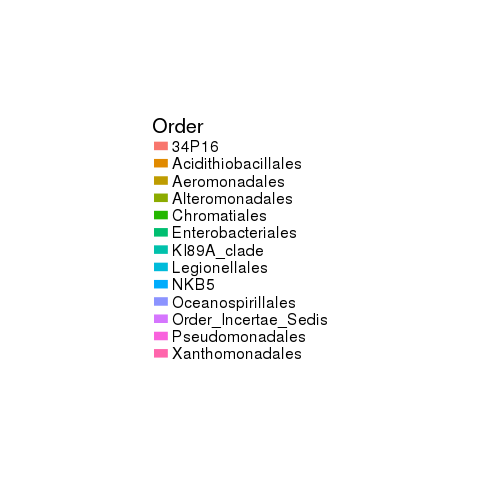

In [233]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [39]:
%%R 


outFile = 'Gamma-Proteo_sparsityCut.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')
#outFile = file.path(figDir, 'Proteo_sparsityCut.pdf')
jpeg(outFile, width=9, height=9, units = "in")
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [40]:
%%R 
# saving legend
outFile = 'Gamma-Proteo_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


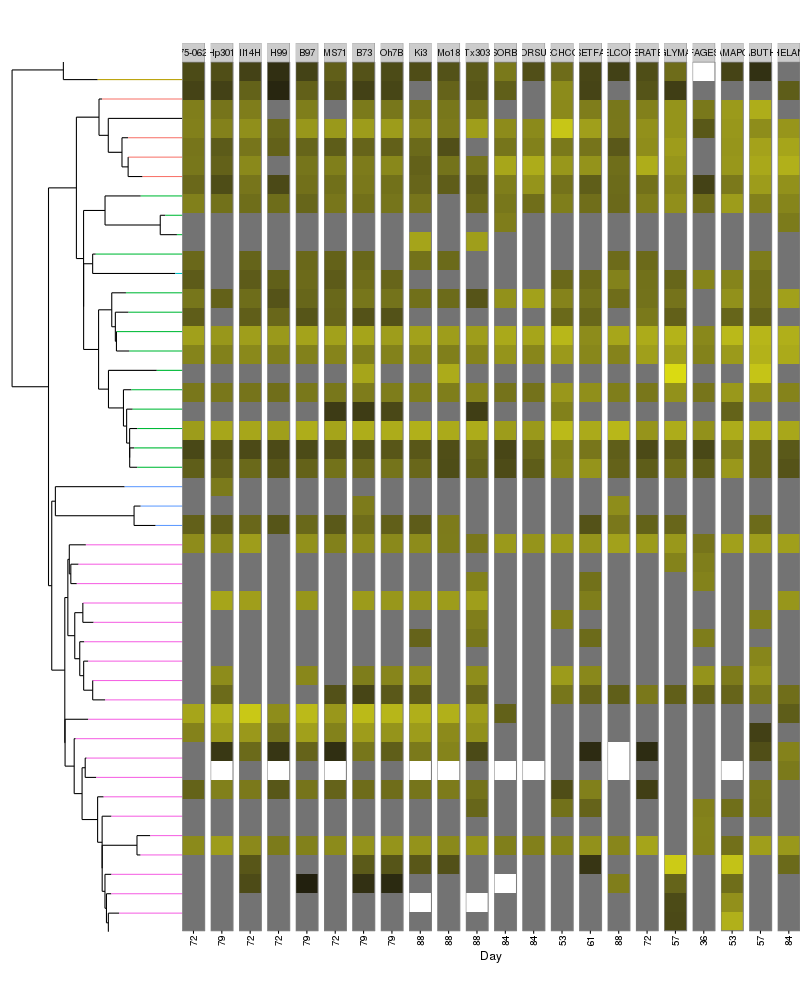

In [234]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Alphaproteobacteria"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank3==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

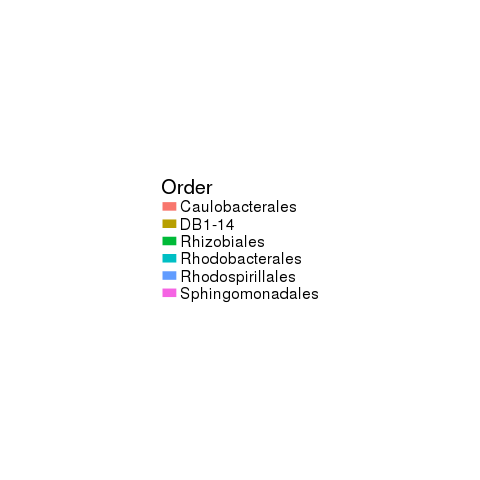

In [235]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [45]:
%%R 

outFile = 'Alpha_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [47]:
%%R 
# saving legend
outFile = 'Alpha-Proteo_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Actinobacteria

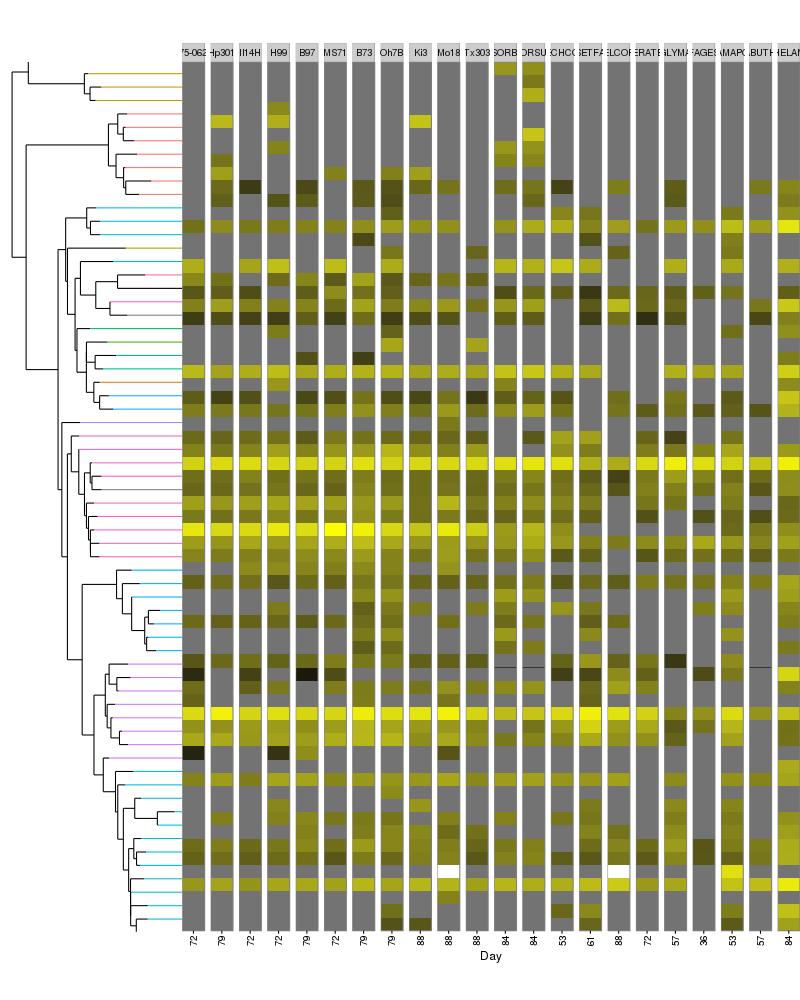

In [236]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Actinobacteria"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank4',
                   legend.title='Order',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

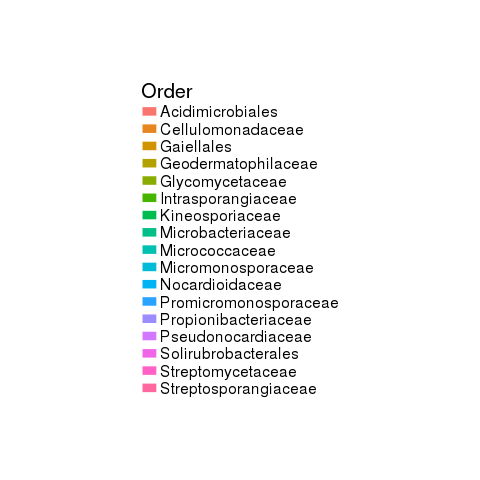

In [237]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [89]:
%%R 

outFile = 'Actino_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [90]:
%%R 
# saving legend
outFile = 'Actino_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Planctomycetes

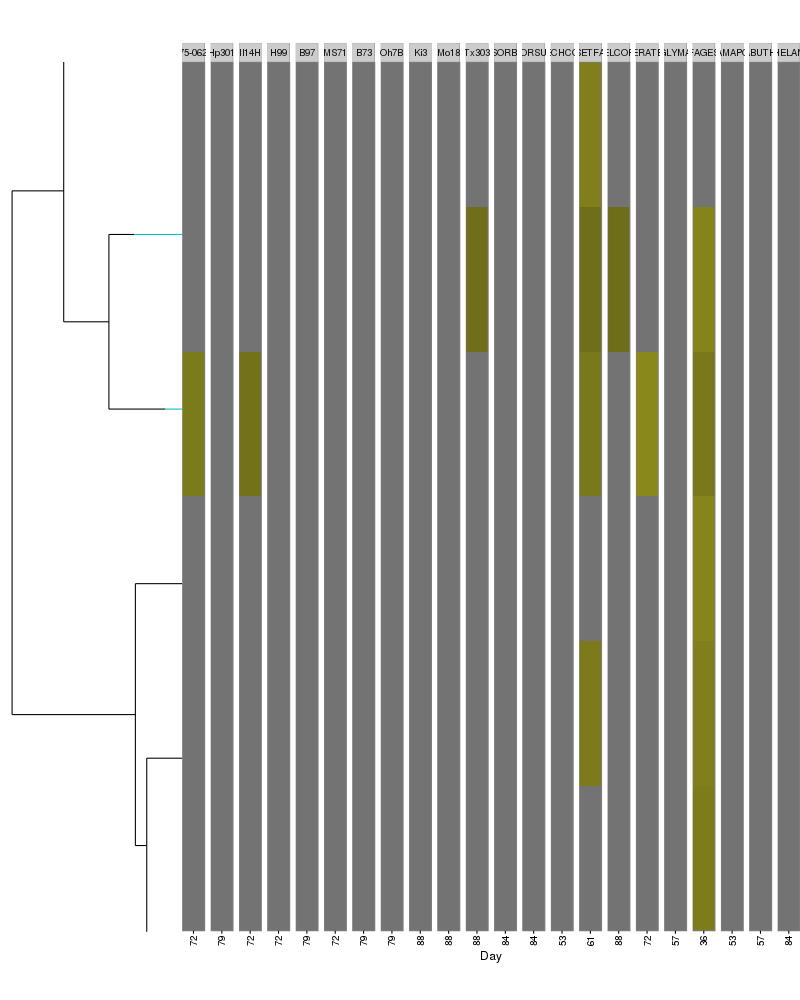

In [239]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Planctomycetes"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))

# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

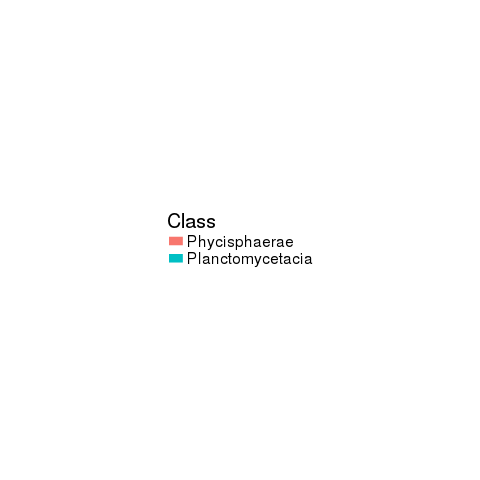

In [240]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [53]:
%%R 

outFile = 'Plancto_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [54]:
%%R 
# saving legend
outFile = 'Plancto_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Acidobacteria

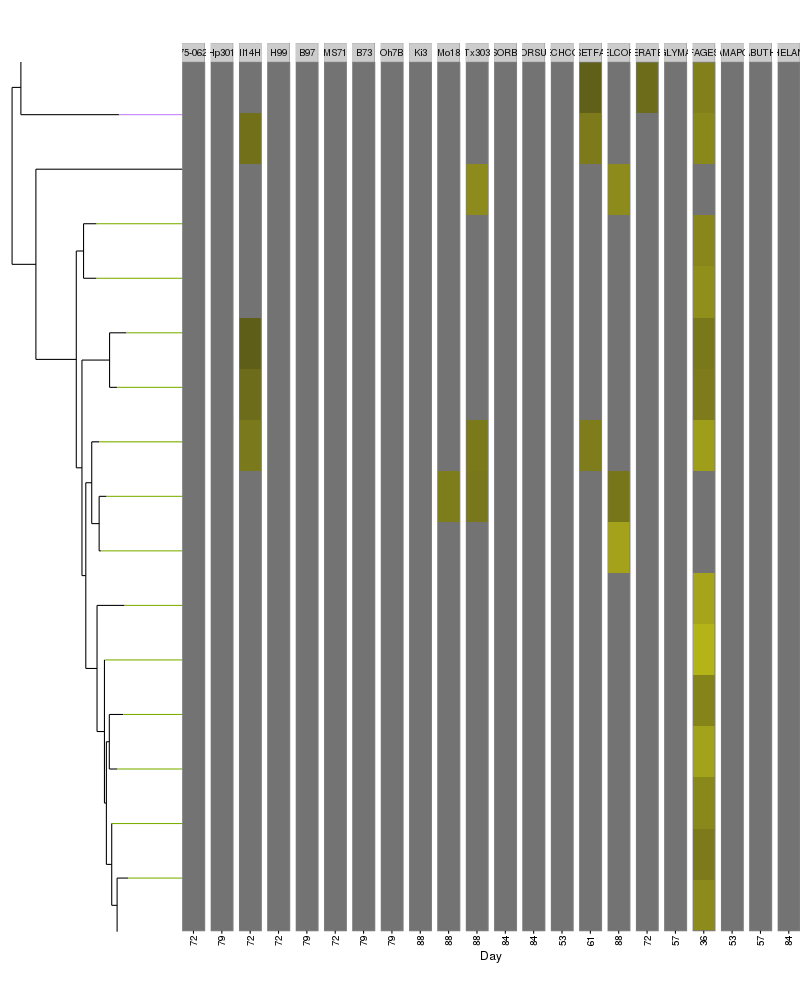

In [241]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Acidobacteria"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))


# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

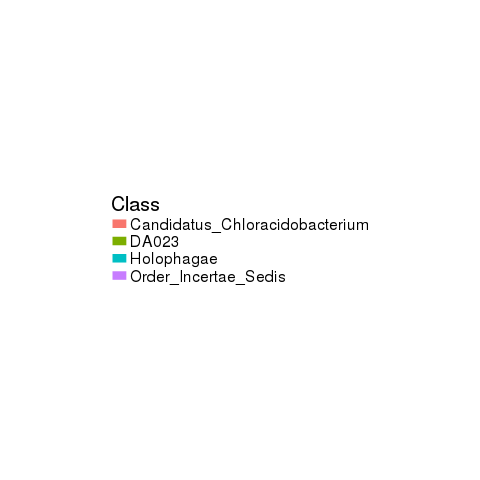

In [242]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [58]:
%%R 

outFile = 'Acido_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [59]:
%%R 
# saving legend
outFile = 'Acido_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Chloroflexi

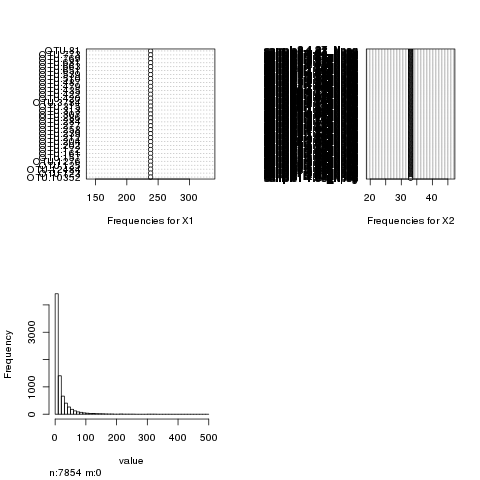

In [251]:
%%R
physeq.Full.resp %>% subset_taxa(Rank2 == "Chloroflexi") %>% otu_table %>% melt %>% hist

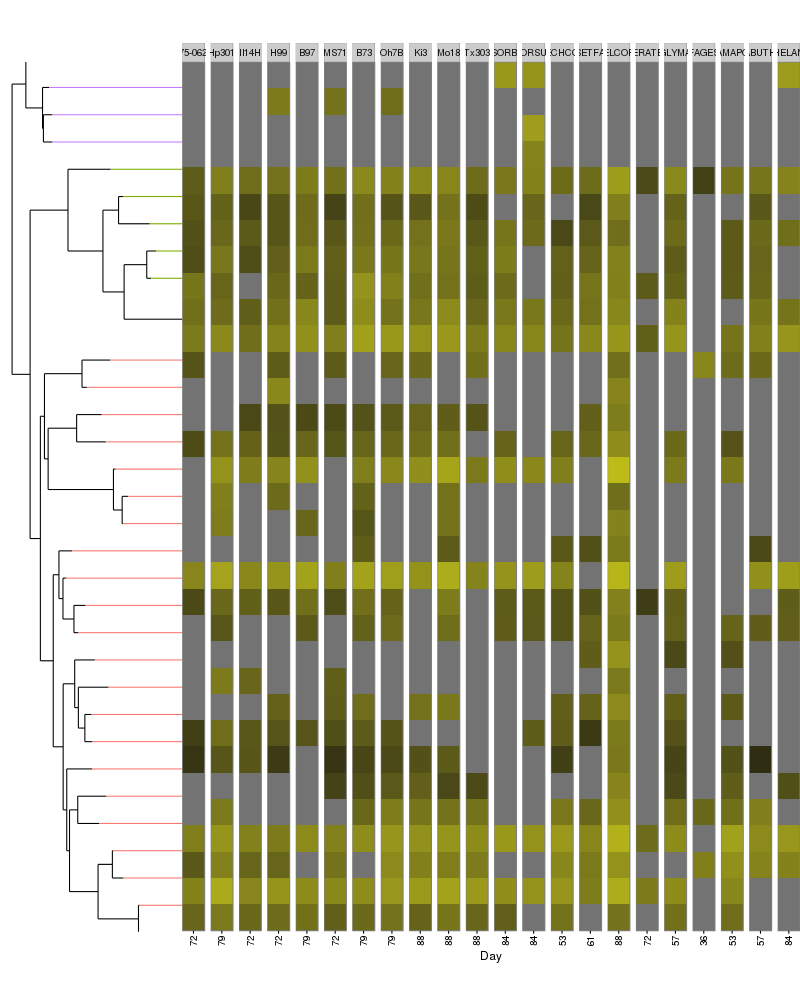

In [244]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Chloroflexi"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))


# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

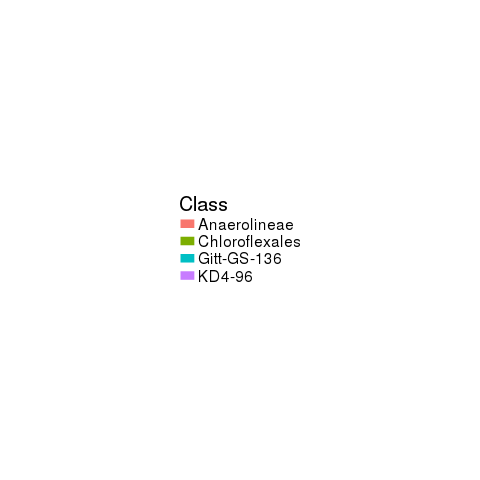

In [252]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [64]:
%%R 

outFile = 'Chloro_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [65]:
%%R 
# saving legend
outFile = 'Chloro_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Bacteroidetes

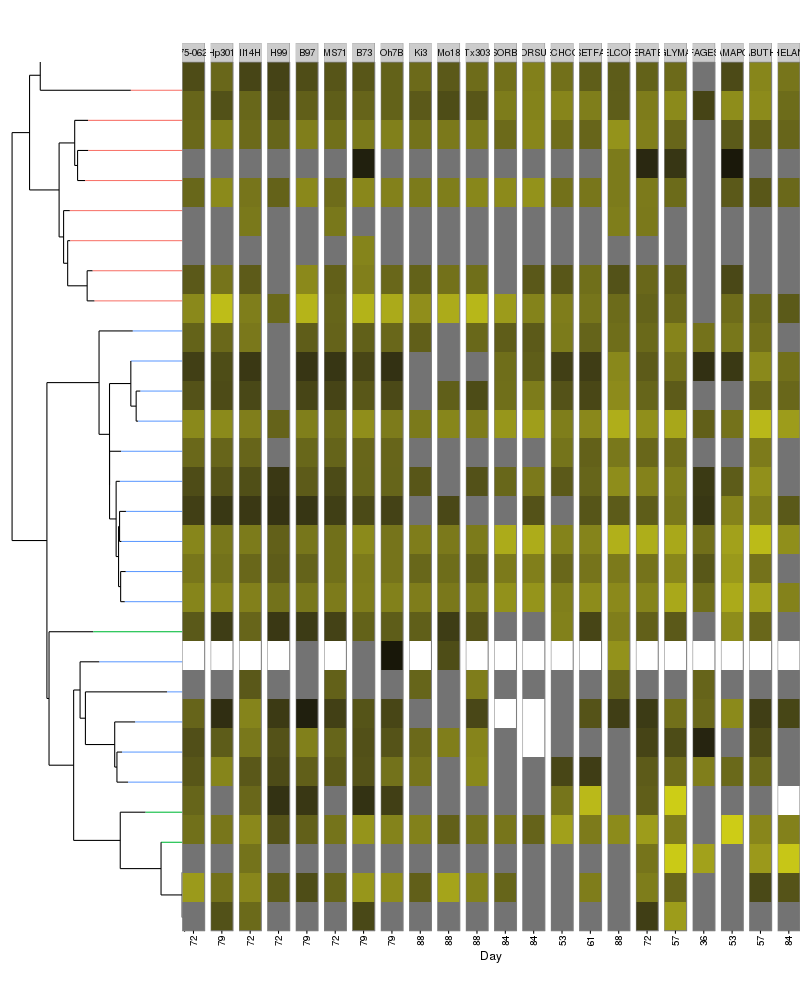

In [253]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Bacteroidetes"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))


# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt) 

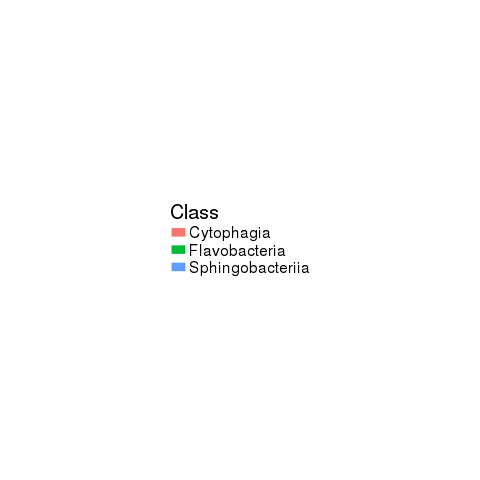

In [254]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [68]:
%%R 

outFile = 'Bacteroidetes_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [69]:
%%R 
# saving legend
outFile = 'Bacteroidetes_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Verrucomicrobia

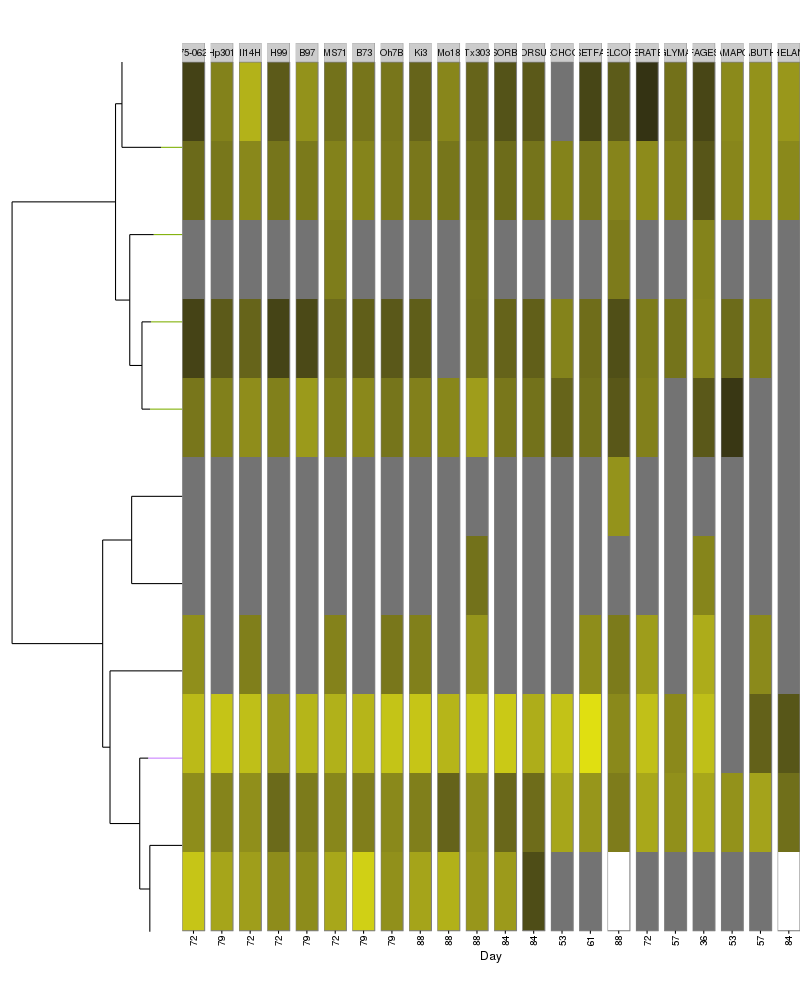

In [255]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Verrucomicrobia"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))


# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

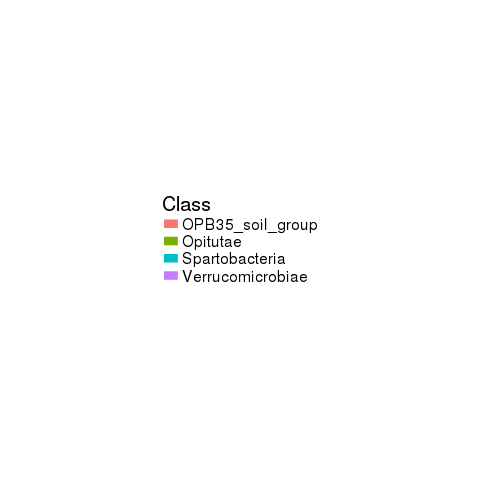

In [257]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [72]:
%%R 

outFile = 'Verruco_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [73]:
%%R 
# saving legend
outFile = 'Verruco_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


## Firmicutes 

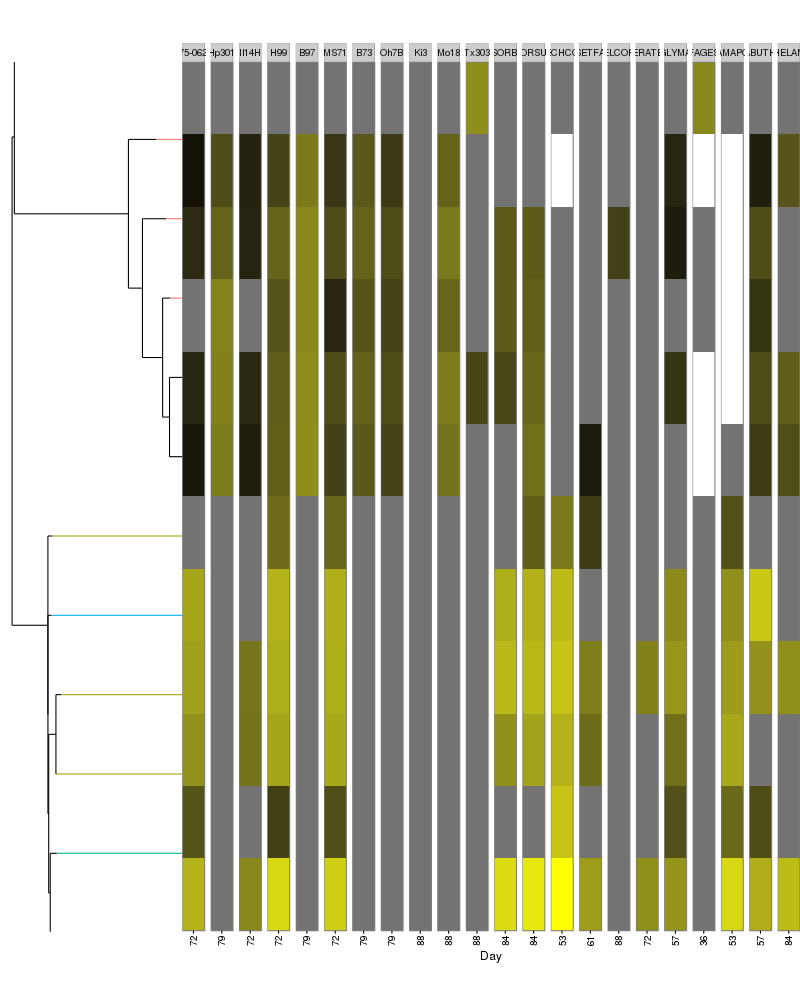

In [263]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Firmicutes"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank6',
                   legend.title='Genus',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))


# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)

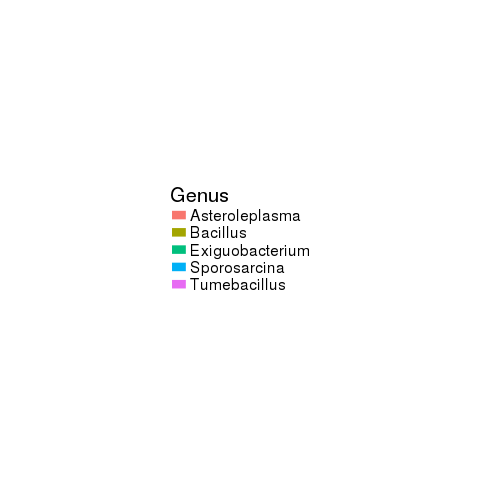

In [264]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [80]:
%%R 

outFile = 'Firmicutes_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [81]:
%%R 
# saving legend
outFile = 'Firmicutes_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


In [104]:
%%R
TT = physeq.Full %>% tax_table %>% data.frame
colnames(TT)
TT[row.names(TT) == "OTU.1001",]

            Rank1      Rank2           Rank3              Rank4
OTU.1001 Bacteria Firmicutes Erysipelotrichi Erysipelotrichales
                       Rank5          Rank6                Rank7 Rank8
OTU.1001 Erysipelotrichaceae Asteroleplasma uncultured_bacterium  <NA>


In [101]:
%%R
tax
df.family = df.l2fc[!is.na(df.l2fc$Rank5),] 

Pb_sel = df.family$Rank5 == "Paenibacillaceae"

Pb = df.family[Pb_sel,] %>% arrange(p.adj)
Pb[,c("Rank5", "Rank6", "p.adj")]

               Rank5         Rank6        p.adj
1   Paenibacillaceae Paenibacillus 2.867822e-09
2   Paenibacillaceae Paenibacillus 2.871479e-09
3   Paenibacillaceae Paenibacillus 7.365414e-06
4   Paenibacillaceae Paenibacillus 1.094995e-05
5   Paenibacillaceae Paenibacillus 5.483978e-05
6   Paenibacillaceae Paenibacillus 7.720390e-05
7   Paenibacillaceae Paenibacillus 9.986144e-05
8   Paenibacillaceae Paenibacillus 2.706554e-04
9   Paenibacillaceae Paenibacillus 2.850030e-04
10  Paenibacillaceae Paenibacillus 2.941849e-04
11  Paenibacillaceae Paenibacillus 4.246286e-04
12  Paenibacillaceae Paenibacillus 4.753803e-04
13  Paenibacillaceae Paenibacillus 7.053511e-04
14  Paenibacillaceae Paenibacillus 1.385811e-03
15  Paenibacillaceae Paenibacillus 1.767881e-03
16  Paenibacillaceae Paenibacillus 2.385436e-03
17  Paenibacillaceae Paenibacillus 2.890407e-03
18  Paenibacillaceae Paenibacillus 3.030312e-03
19  Paenibacillaceae Paenibacillus 5.057714e-03
20  Paenibacillaceae Paenibacillus 5.278

## Gemmatimonadetes

In [260]:
%%R -w 800 -h 1000

# phylum selection
phylum = "Gemmatimonadetes"
physeq_1phy = subset_taxa(physeq.Full.resp, Rank2==phylum)

# tree plot
p.tree = plot_tree(physeq_1phy, 
                   color.rank='Rank3',
                   legend.title='Class',
                   y.expand=c(-0.002,-0.002),
                   plot.margin=unit(c(0,-0.1,0,0), 'cm'))


# order metadata
df.l2fc.s = df.l2fc %>%
    select(-Rank1, -Rank2, -Rank3, -Rank4, -Rank5, -Rank6, -Rank7, -Rank8)
## substrates by similarity of incorporators (full tree)
df.l2fc.ord = df.l2fc.s
df.l2fc.ord = order_plants_by_phylogeny(df.l2fc.ord, physeq.Full, cores=nprocs)
## taxa by tree
df.l2fc.ord = order_metadata_to_tree(physeq_1phy, df.l2fc.ord) 

# plotting metadata
## plot.margin: top, right, bottom, left 
p.responders = responders_plot(df.l2fc.ord, plot.margin=unit(c(1.52,0,1.33,-0.73), 'cm'))



# plotting
gt = resize_ggplots(list(p.tree, p.responders),
                    widths=c(.6,1.8))
do.call(grid.arrange, gt)


Error: Faceting variables must have at least one value


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error: Faceting variables must have at least one value

  res = super(Function, self).__call__(*new_args, **new_kwargs)


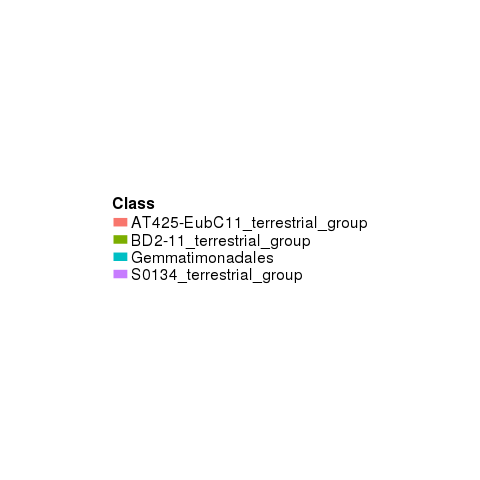

In [84]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

In [85]:
%%R 

outFile = 'Gemma_sparCut3in3.jpeg'
outFile = paste(c(figDir, outFile), collapse='/')

jpeg(outFile, width=9, height=9, units = "in", res = 150)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


In [86]:
%%R 
# saving legend
outFile = 'Gemma_sparCut3in3_leg.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=500 / 65, height=500 / 65)
my.legend = g_legend(p.tree)
grid.draw(my.legend)
dev.off()

png 
  2 


In [247]:
%%R -i figDir

outFile = 'Gemma_sparCut3in3.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
pdf(outFile, width=800 / 65, height=1300 / 65)
do.call(grid.arrange, gt)
dev.off()

png 
  2 


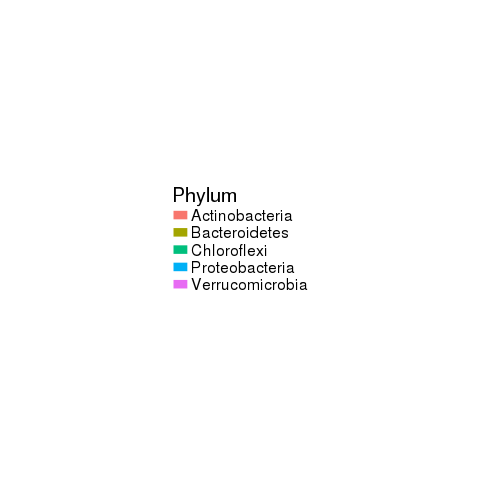

In [532]:
%%R 
my.legend = g_legend(p.tree)
grid.draw(my.legend)

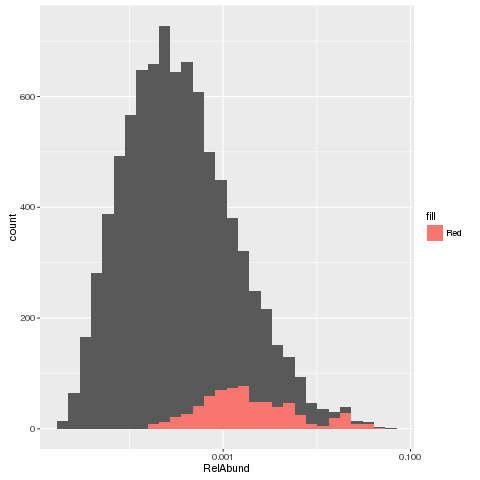

In [525]:
%%R
coredata = filter(df.l2fc, OTU %in% CoreTaxa) 

respdata = filter(df.l2fc, p.adj < 0.05)
p1 = ggplot() + 
    geom_histogram(data = respdata, aes(x = RelAbund)) + 
    scale_x_log10() +
    geom_histogram(data = coredata, aes(x = RelAbund, fill = "Red"))


p1